In [1]:
%pip install pandas numpy matplotlib yfinance backtrader

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# All the necessary libraries for stock price data, data handling, data visualization, etc.

In [3]:
# Download AAPL stock data (5yrs)
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2025-01-01")

# Get an idea for what the data looks like
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796021  72.856613  71.545387  71.799873  135480400
2020-01-03  72.088295  72.851761  71.862892  72.020432  146322800
2020-01-06  72.662712  72.701492  70.954002  71.206070  118387200
2020-01-07  72.320984  72.929329  72.100426  72.672417  108872000
2020-01-08  73.484352  73.787315  72.022858  72.022858  132079200


In [4]:
# More insight into the data
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,152.344947,153.876450,150.637191,152.189645,9.057384e+07
std,42.119394,42.260654,41.895275,42.062840,5.325460e+07
min,54.509754,55.513122,51.652713,55.411085,2.323470e+07
25%,127.085930,128.211028,125.072541,126.527653,5.546825e+07
50%,150.926796,152.679048,148.982992,150.745903,7.627980e+07
75%,177.025860,178.586162,175.451086,176.830826,1.077425e+08
max,259.019989,260.100006,257.630005,258.190002,4.265100e+08


In [5]:
'''
Here, we'll implement a trading strategy like Moving Average Crossover, with Buy and Sell signals.
It makes use of Short and Long Term Moving Average, which we'll define and implement below.
'''

# Define moving avgs.
df['SMA_50'] = df['Close'].rolling(window=50).mean() # Short-term MA
df['SMA_200'] = df['Close'].rolling(window=200).mean() # Long-term MA

# buy/sell signals
df['Signal'] = 0 # default: no position
df.loc[df['SMA_50'] > df['SMA_200'], 'Signal'] = 1 # buy
df.loc[df['SMA_50'] < df['SMA_200'], 'Signal'] = -1 # sell

# display the buy/sell signals
print(df[['Close', 'SMA_50', 'SMA_200', 'Signal']].tail(10))

Price            Close      SMA_50     SMA_200 Signal
Ticker            AAPL                               
Date                                                 
2024-12-17  253.479996  233.345886  209.329007      1
2024-12-18  248.050003  233.796448  209.721724      1
2024-12-19  249.789993  234.206494  210.128123      1
2024-12-20  254.490005  234.720528  210.558619      1
2024-12-23  255.270004  235.279930  210.984397      1
2024-12-24  258.200012  235.823014  211.414761      1
2024-12-26  259.019989  236.331553  211.846834      1
2024-12-27  255.589996  236.812848  212.272219      1
2024-12-30  252.199997  237.218951  212.671337      1
2024-12-31  250.419998  237.532516  213.063449      1


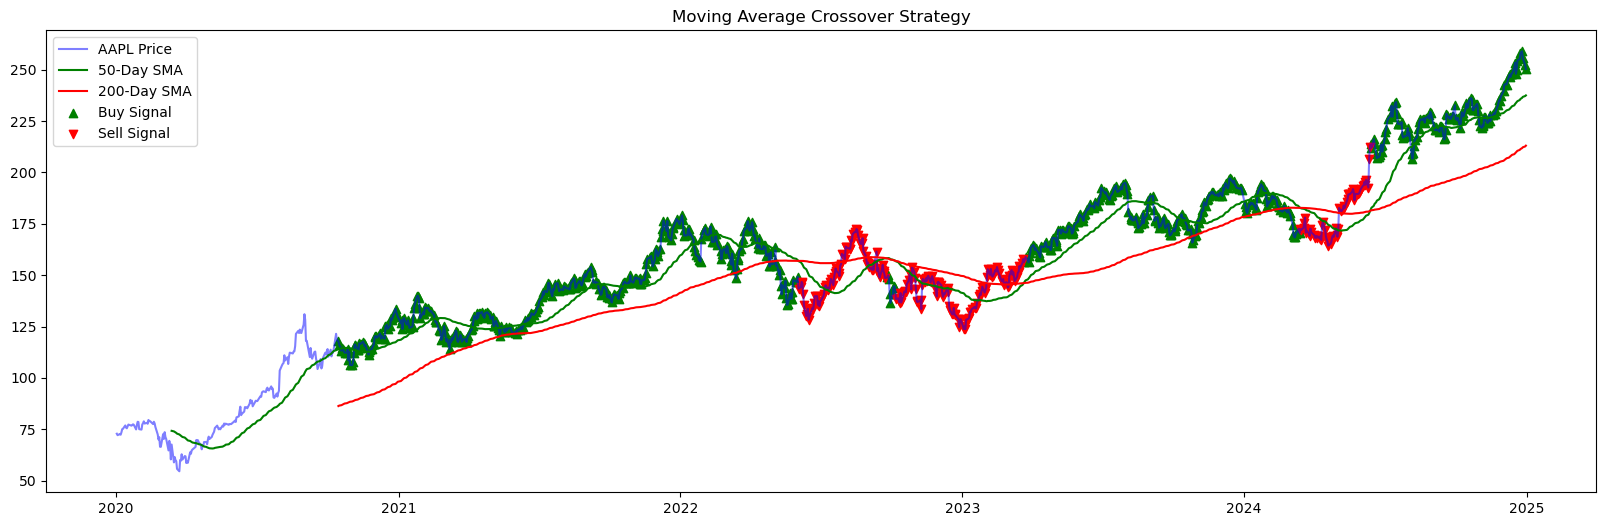

In [6]:
'''
Now that it's implemented in data, we can move on to visualizing the stock price and plotting these buy/sell signals
For this we'll use matplotlib
'''

# Plot stock price, SMA 50 and SMA 200
plt.figure(figsize=(20,6))
plt.plot(df.index, df['Close'], label='AAPL Price', color='blue', alpha=0.5)
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='green')
plt.plot(df.index, df['SMA_200'], label='200-Day SMA', color='red')

# Plot buy/sell signals
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], label='Sell Signal', marker='v', color='red', alpha=1)

# Plotting it all
plt.legend()
plt.title("Moving Average Crossover Strategy")
plt.show()

In [7]:
df.columns = df.columns.get_level_values(0)  # Fix multi-index issue
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Keep required columns

<IPython.core.display.Javascript object>

Starting Portfolio Value: 10000.00
Starting Portfolio Value: 10064.68


<IPython.core.display.Javascript object>

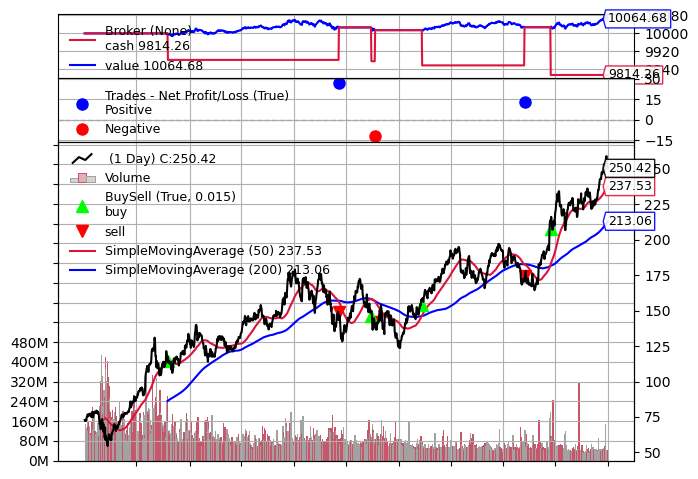

In [12]:
'''
Now that we see it in action, we can evaluate how profitable the strategy is using backtrader
'''
plt.clf()
class MovingAverageStrategy(bt.Strategy):
    def __init__(self):
        self.sma50 = bt.indicators.SimpleMovingAverage(self.data.close, period=50)
        self.sma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)

    def next(self):
        if self.sma50[0] > self.sma200[0] and not self.position:
            self.buy()
        elif self.sma50[0] < self.sma200[0] and self.position:
            self.sell()

# Creating the Backtesting Engine
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)
cerebro.addstrategy(MovingAverageStrategy)
cerebro.broker.set_cash(10000)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the actual Backtest
cerebro.run()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

# Extract the first figure from the list (figs is a list of figures
fig = figs[0][0]
fig